# やること


- 頑張って精度あげる
  - 前の 10 点から平滑化する
  - C の推論値をいい感じにしたいので、R と L を正解値で固定して学習しないようにしてみる
- ノイズクリッピングのパラメータ変更
- シーケンスサイズ変更
- サンプリング数変更
- 使う周期数


In [2]:
from dataclasses import asdict, dataclass

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn, optim

from src.utils.load_data import path_list
from src.utils.models import BuckConverterCell, GRUModel
from src.utils.plot_data import (
    plot_compare_tail,
    plot_param_learning_progress,
    plot_u_vs_iL_vC,
)
from src.utils.save_log import (
    create_result_dir,
    init_log,
    save_figure_to_log,
)

# 乱数固定用の処理
seed = 10
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)

In [ ]:
# keep_log: bool = True
keep_log: bool = False


@dataclass(frozen=True)
class Params:
    data_path: str = path_list.path3

    # 真値パラメータ
    L_true: float = 223.6e-6
    C_true: float = 73.8e-6
    R_true: float = 5

    Vin: int = 10
    Vref: int = 5
    duty: float = Vref / Vin
    f_sw: float = 1e5  # スイッチング周波数
    T: float = 1 / f_sw  # 1周期の実時間
    cycles: int = 1000
    samples_per_cycle: int = 200

    train_ratio = 0.3
    valid_ratio = 0.3
    # test_ratio = 1 - train_ratio - valid_ratio

    clipped_k: float = 2.0

    # 学習パラメータ
    L_init = 200e-6
    C_init = 100e-6
    R_init = 8.0

    # 異なるパラメータに異なる学習率を設定
    lr_l = 5e-2
    lr_c = 1e-2
    lr_r = 2e-2

    epochs = 50000

    # GRU学習用のデータ準備（時系列データ）
    seq_length = 10

    gru_lr = 0.001
    gru_epochs = 200


params = Params()


In [4]:
# ログ保存の初期化
if keep_log:
    result_dir = create_result_dir(
        "note3",
        config_dict=asdict(params),
    )
    log_path = init_log(result_dir, "actual_machine_notebooks/note3/note_sim.ipynb")

# BuckConverterCell


## 前処理


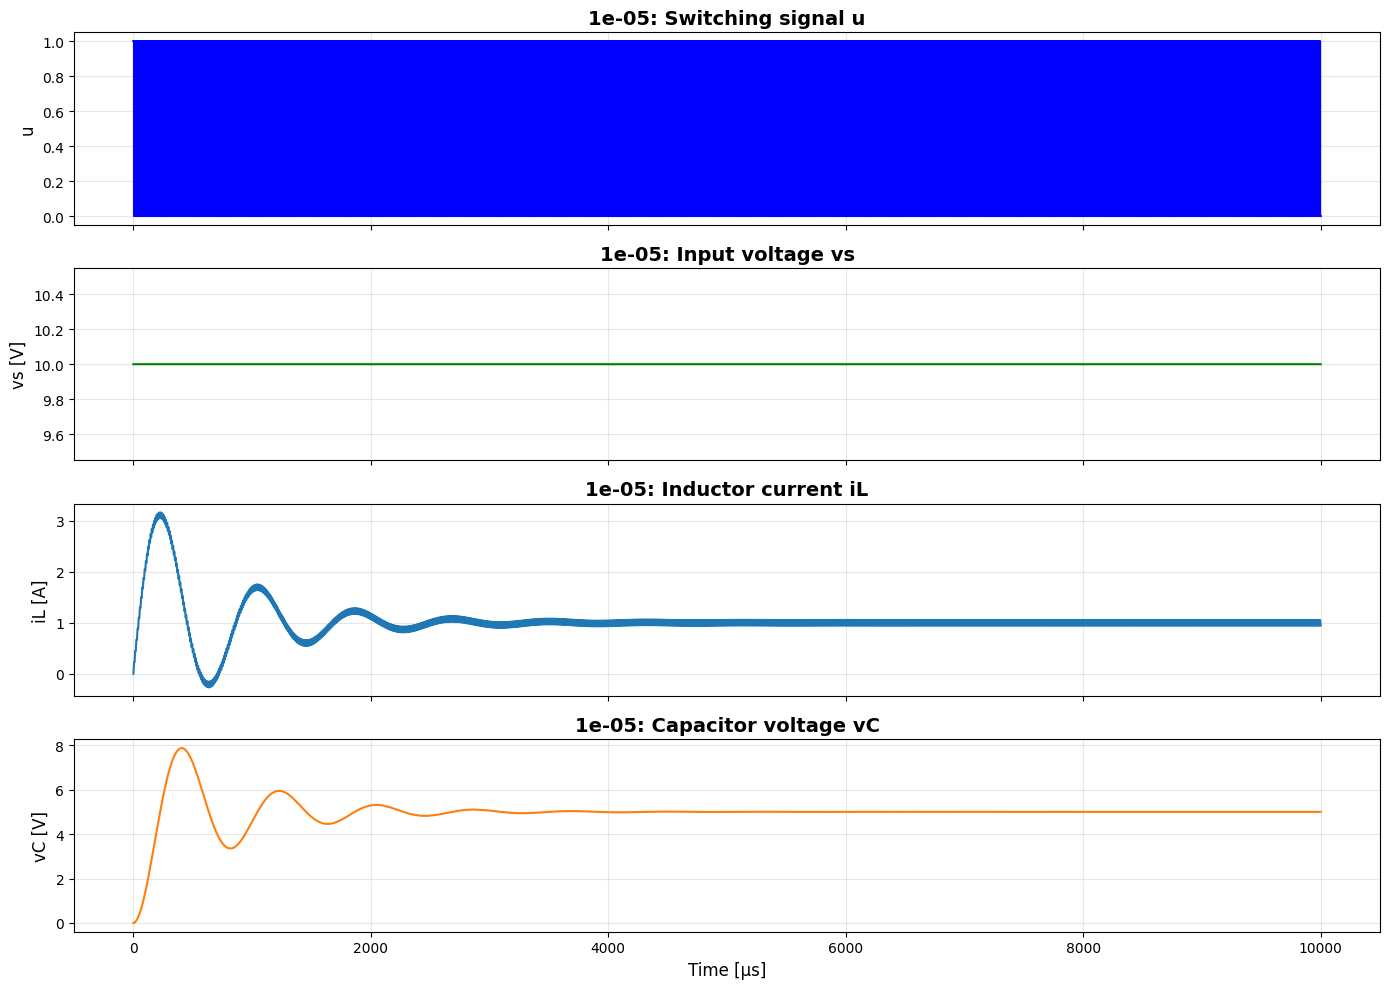

In [5]:
t_raw: np.ndarray = np.linspace(
    0,
    params.cycles * params.T,
    params.cycles * params.samples_per_cycle + 1,
)
dt = t_raw[1:] - t_raw[:-1]

# スイッチング信号
duty_phase = (t_raw[:-1] % params.T) / params.T
u_raw = (duty_phase < params.duty).astype(int)

# 入力電圧
vs_raw = np.ones(len(t_raw) - 1) * params.Vin

true_buck_converter_cell = BuckConverterCell(
    L_init=params.L_true,
    C_init=params.C_true,
    R_init=params.R_true,
)
x_tensor = torch.tensor(np.c_[vs_raw, u_raw, dt], dtype=torch.float32)

il_list = []
vc_list = []

# シミュレーション実行
with torch.no_grad():
    h_current: torch.Tensor = torch.zeros(1, 2)  # [i_L=0, v_C=0]
    il_list.append(h_current[0, 0].item())  # i_L
    vc_list.append(h_current[0, 1].item())  # v_C

    for j in range(len(t_raw) - 1):
        h_current = true_buck_converter_cell(h_current, x_tensor[j : j + 1])

        il_list.append(h_current[0, 0].item())  # i_L
        vc_list.append(h_current[0, 1].item())  # v_C


iL_raw = torch.tensor(np.array(il_list), dtype=torch.float32)
vC_raw = torch.tensor(np.array(vc_list), dtype=torch.float32)

fig, ax = plot_u_vs_iL_vC(
    t_raw,
    u_raw,
    vs_raw,
    iL_raw,
    vC_raw,
    params.T,
)

if keep_log:
    save_figure_to_log(fig, "u_vs_iL_vC.png", result_dir)


In [6]:
t_downsampled = t_raw[-params.samples_per_cycle * 10 - 1 :]
iL_downsampled = iL_raw[-params.samples_per_cycle * 10 - 1 :]
iL_clipped = iL_raw[-params.samples_per_cycle * 10 - 1 :]
vC_downsampled = vC_raw[-params.samples_per_cycle * 10 - 1 :]
vC_clipped = vC_raw[-params.samples_per_cycle * 10 - 1 :]
u = u_raw[-params.samples_per_cycle * 10 :]
vs = vs_raw[-params.samples_per_cycle * 10 :]


In [7]:
# train, valid, test の分割
dt = t_downsampled[1:] - t_downsampled[:-1]

# numpy配列をテンソルに変換
dt_tensor = torch.tensor(dt, dtype=torch.float32)
u_tensor = torch.tensor(u, dtype=torch.float32)
vs_tensor = torch.tensor(vs, dtype=torch.float32)
iL_clipped_tensor = torch.tensor(iL_clipped, dtype=torch.float32)
vC_clipped_tensor = torch.tensor(vC_clipped, dtype=torch.float32)

# train
train_len = int(len(dt) * params.train_ratio)

t_train = t_downsampled[: train_len + 1]
dt_train = dt_tensor[:train_len]
u_train = u_tensor[:train_len]
vs_train = vs_tensor[:train_len]
iL_clipped_train = iL_clipped_tensor[: train_len + 1]
vC_clipped_train = vC_clipped_tensor[: train_len + 1]

h_clipped_train = torch.stack(
    [iL_clipped_train[:-1], vC_clipped_train[:-1]],
    dim=1,
)
x_train = torch.stack([vs_train, u_train, dt_train], dim=1)
target_clipped_train = torch.stack(
    [iL_clipped_train[1:], vC_clipped_train[1:]],
    dim=1,
)


# valid
valid_len = int(len(dt) * params.valid_ratio)

t_valid = t_downsampled[train_len : train_len + valid_len]
dt_valid = dt_tensor[train_len : train_len + valid_len]
u_valid = u_tensor[train_len : train_len + valid_len]
vs_valid = vs_tensor[train_len : train_len + valid_len]
iL_clipped_valid = iL_clipped_tensor[train_len : train_len + valid_len + 1]
vC_clipped_valid = vC_clipped_tensor[train_len : train_len + valid_len + 1]

h_clipped_valid = torch.stack(
    [iL_clipped_valid[:-1], vC_clipped_valid[:-1]],
    dim=1,
)
x_valid = torch.stack([vs_valid, u_valid, dt_valid], dim=1)
target_clipped_valid = torch.stack(
    [iL_clipped_valid[1:], vC_clipped_valid[1:]],
    dim=1,
)

# test
t_test = t_downsampled[train_len + valid_len :]
dt_test = dt_tensor[train_len + valid_len :]
u_test = u_tensor[train_len + valid_len :]
vs_test = vs_tensor[train_len + valid_len :]
iL_clipped_test = iL_clipped_tensor[train_len + valid_len :]
vC_clipped_test = vC_clipped_tensor[train_len + valid_len :]

h_clipped_test = torch.stack(
    [iL_clipped_test[:-1], vC_clipped_test[:-1]],
    dim=1,
)
x_test = torch.stack([vs_test, u_test, dt_test], dim=1)
target_clipped_test = torch.stack(
    [iL_clipped_test[1:], vC_clipped_test[1:]],
    dim=1,
)

print(f"{h_clipped_train.shape=}")
print(f"{x_train.shape=}")
print(f"{target_clipped_train.shape=}")

print(f"{h_clipped_valid.shape=}")
print(f"{x_valid.shape=}")
print(f"{target_clipped_valid.shape=}")

print(f"{h_clipped_test.shape=}")
print(f"{x_test.shape=}")
print(f"{target_clipped_test.shape=}")


h_clipped_train.shape=torch.Size([600, 2])
x_train.shape=torch.Size([600, 3])
target_clipped_train.shape=torch.Size([600, 2])
h_clipped_valid.shape=torch.Size([600, 2])
x_valid.shape=torch.Size([600, 3])
target_clipped_valid.shape=torch.Size([600, 2])
h_clipped_test.shape=torch.Size([800, 2])
x_test.shape=torch.Size([800, 3])
target_clipped_test.shape=torch.Size([800, 2])


/var/folders/f_/5hh5787972x33swmy27z8q0m0000gn/T/ipykernel_84144/3881181208.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  iL_clipped_tensor = torch.tensor(iL_clipped, dtype=torch.float32)
/var/folders/f_/5hh5787972x33swmy27z8q0m0000gn/T/ipykernel_84144/3881181208.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vC_clipped_tensor = torch.tensor(vC_clipped, dtype=torch.float32)


## 学習


In [8]:
buck_converter_cell = BuckConverterCell(
    L_init=params.L_init,
    C_init=params.C_init,
    R_init=params.R_init,
)

optimizer = optim.Adam(
    [
        {"params": [buck_converter_cell.log_L], "lr": params.lr_l},
        {"params": [buck_converter_cell.log_C], "lr": params.lr_c},
        {"params": [buck_converter_cell.log_R], "lr": params.lr_r},
    ]
)

loss_fn = nn.MSELoss()

# 損失履歴を保存
loss_history = {"train": [], "valid": []}
param_history = {"L": [], "C": [], "R": []}

# 学習ループ
for epoch in range(params.epochs):
    # 学習モード
    buck_converter_cell.train()
    optimizer.zero_grad()
    h_pred_train = buck_converter_cell(h_clipped_train, x_train)
    train_loss = loss_fn(h_pred_train, target_clipped_train)
    train_loss.backward()
    optimizer.step()

    loss_history["train"].append(train_loss.item())

    # 検証モード（勾配計算なし）
    buck_converter_cell.eval()
    with torch.no_grad():
        h_pred_valid = buck_converter_cell(h_clipped_valid, x_valid)
        valid_loss = loss_fn(h_pred_valid, target_clipped_valid)
        loss_history["valid"].append(valid_loss.item())

    # パラメータの履歴を保存
    param_history["L"].append(buck_converter_cell.log_L.exp().item())
    param_history["C"].append(buck_converter_cell.log_C.exp().item())
    param_history["R"].append(buck_converter_cell.log_R.exp().item())

    if epoch % 50 == 0:
        output_line = (
            f"Epoch {epoch}: Train Loss={train_loss.item():.6e}, "
            f"Valid Loss={valid_loss.item():.6e}\n"
            f"  L={buck_converter_cell.log_L.exp().item() * 1e6:.1f}µH "
            f"(true={params.L_true * 1e6:.1f})"
            f"C={buck_converter_cell.log_C.exp().item() * 1e6:.1f}µF "
            f"(true={params.C_true * 1e6:.1f})"
            f"R={buck_converter_cell.log_R.exp().item():.2f}Ω "
            f"(true={params.R_true:.1f})"
        )
        print(output_line)

# テストデータでの評価
buck_converter_cell.eval()
with torch.no_grad():
    h_pred_test = buck_converter_cell(h_clipped_test, x_test)
    test_loss = loss_fn(h_pred_test, target_clipped_test)

print(f"Final test loss: {test_loss.item():.6e}")


Epoch 0: Train Loss=2.629905e-08, Valid Loss=1.910905e-08
  L=209.7µH (true=223.6)C=100.8µF (true=73.8)R=7.86Ω (true=5.0)
Epoch 50: Train Loss=1.401071e-10, Valid Loss=1.421916e-10
  L=222.4µH (true=223.6)C=118.3µF (true=73.8)R=4.85Ω (true=5.0)
Epoch 100: Train Loss=3.437231e-11, Valid Loss=3.441883e-11
  L=223.5µH (true=223.6)C=118.4µF (true=73.8)R=5.00Ω (true=5.0)
Epoch 150: Train Loss=3.349857e-11, Valid Loss=3.336696e-11
  L=223.6µH (true=223.6)C=118.0µF (true=73.8)R=5.00Ω (true=5.0)
Epoch 200: Train Loss=3.280331e-11, Valid Loss=3.280320e-11
  L=223.6µH (true=223.6)C=117.6µF (true=73.8)R=5.00Ω (true=5.0)
Epoch 250: Train Loss=3.280320e-11, Valid Loss=3.280320e-11
  L=223.6µH (true=223.6)C=117.2µF (true=73.8)R=5.00Ω (true=5.0)
Epoch 300: Train Loss=3.280320e-11, Valid Loss=3.280320e-11
  L=223.6µH (true=223.6)C=116.7µF (true=73.8)R=5.00Ω (true=5.0)
Epoch 350: Train Loss=3.255878e-11, Valid Loss=3.252637e-11
  L=223.6µH (true=223.6)C=116.3µF (true=73.8)R=5.00Ω (true=5.0)
Epoch 400: 

## 結果確認


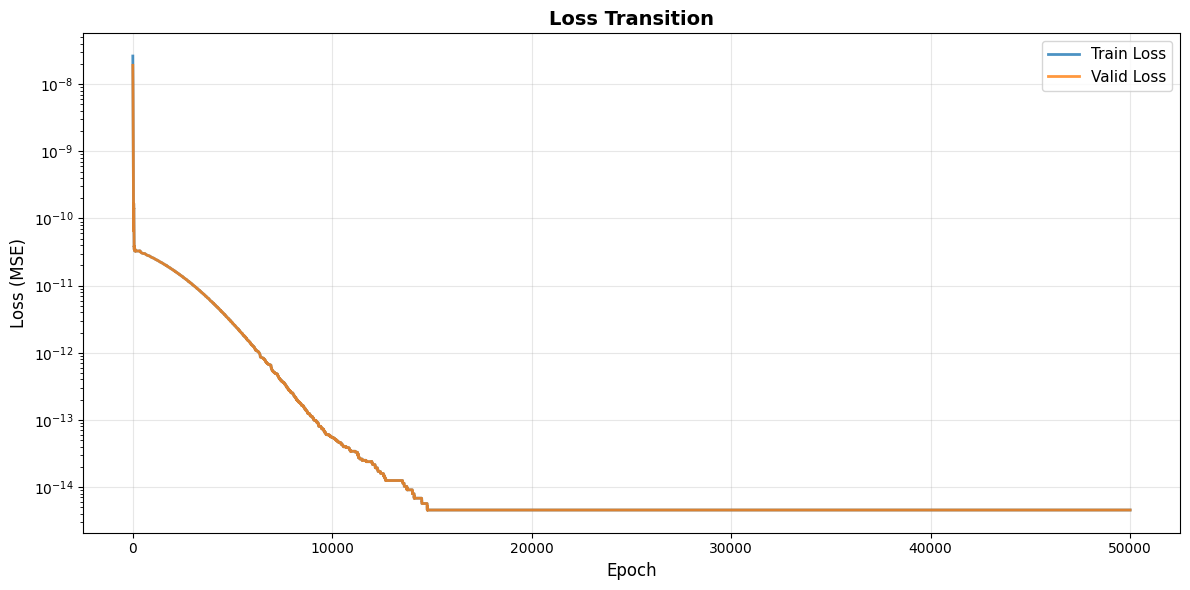

In [9]:
# Lossの遷移をグラフ表示
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

epochs_list = range(1, params.epochs + 1)
ax.plot(epochs_list, loss_history["train"], label="Train Loss", linewidth=2, alpha=0.8)
ax.plot(epochs_list, loss_history["valid"], label="Valid Loss", linewidth=2, alpha=0.8)

ax.set_xlabel("Epoch", fontsize=12)
ax.set_ylabel("Loss (MSE)", fontsize=12)
ax.set_title("Loss Transition", fontsize=14, fontweight="bold")
ax.set_yscale("log")
ax.grid(True, alpha=0.3)
ax.legend(fontsize=11)

plt.tight_layout()
plt.show()

# 画像をログに保存
if keep_log:
    save_figure_to_log(fig, "loss_transition", result_dir, "Lossの遷移")


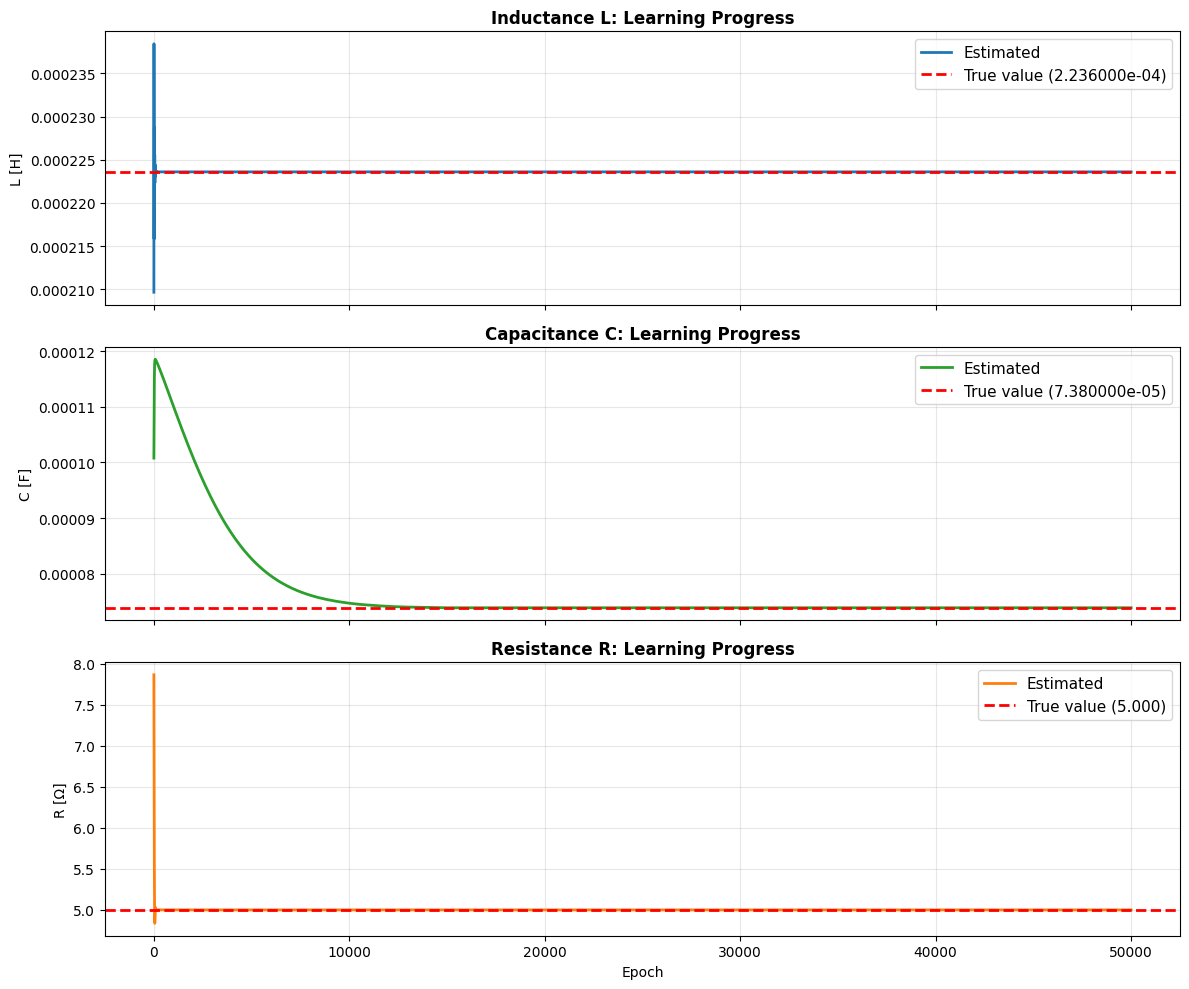

In [10]:
# 回路パラメータの学習による変化をグラフ表示
fig, ax = plot_param_learning_progress(
    param_history,
    params.L_true,
    params.C_true,
    params.R_true,
    params.epochs,
)
plt.show()

# 画像をログに保存
if keep_log:
    save_figure_to_log(
        fig, "parameter_learning", result_dir, "回路パラメータの学習による変化"
    )


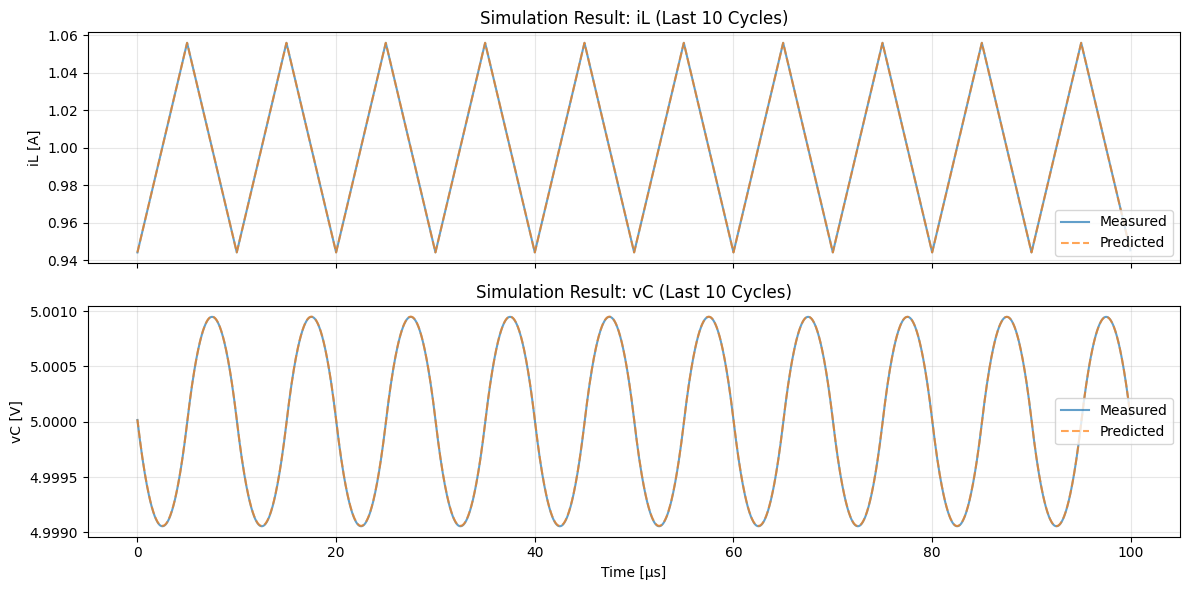

In [11]:
t_sim: np.ndarray = np.linspace(
    0,
    1000 * params.T,
    1000 * params.samples_per_cycle + 1,
)

dt_sim: np.ndarray = np.diff(t_sim)

# スイッチング信号
duty_phase = (t_sim[:-1] % params.T) / params.T
u_sim = (duty_phase < params.duty).astype(int)

# 入力電圧
vs_sim = np.ones(len(t_sim) - 1) * params.Vin
x_tensor = torch.tensor(np.c_[vs_sim, u_sim, dt_sim], dtype=torch.float32)

h_sim = [torch.zeros(1, 2)]

# シミュレーション実行
with torch.no_grad():
    for j in range(len(t_sim) - 1):
        h_current = buck_converter_cell(h_sim[-1], x_tensor[j : j + 1])
        h_sim.append(h_current)

h_sim_tensor = torch.cat(h_sim, dim=0)  # shape: (T+1, 2) みたいになる
iL_sim = h_sim_tensor[:, 0]
vC_sim = h_sim_tensor[:, 1]

# グラフ表示
fig, ax = plot_compare_tail(
    t_downsampled,
    iL_clipped,
    vC_clipped,
    "Measured",
    t_sim,
    iL_sim,
    vC_sim,
    "Predicted",
    T=params.T,
    title="Simulation Result",
)


if keep_log:
    save_figure_to_log(
        fig,
        "all_prediction",
        result_dir,
        "シミュレーション結果(0から1000周期までシミュレーションし、定常箇所と実機のデータの比較)",
    )


# GRU


## 前処理

1. 教師データ: (実機データのノイズクリッピング前の波形) - (学習済み BuckConverterCell のおよそ定常部分)
2. 入力データ: iL, vC, vs, u, dt
3. データシーケンスの作成
4. train, valid, test に分割


In [12]:
def create_sequences(
    h_data: torch.Tensor,
    x_data: torch.Tensor,
    noise_data: torch.Tensor,
    seq_len: int,
) -> tuple[torch.Tensor, torch.Tensor]:
    """
    時系列データを作成
    入力: [iL, vC, vs, u, dt, iL_noise, vC_noise]
    出力: [iL_noise, vC_noise]
    """
    sequences = []
    targets = []

    for i in range(len(h_data) - seq_len):
        # 入力特徴量: [iL, vC, vs, u, dt] + 過去のノイズ [iL_noise, vC_noise]
        seq_input = []
        for j in range(seq_len):
            idx = i + j
            # 状態と入力
            features = torch.cat(
                [
                    h_data[idx],  # [iL, vC]
                    x_data[idx],  # [vs, u, dt]
                ]
            )
            # 過去のノイズ（存在する場合）
            if idx > 0:
                noise_features = noise_data[idx - 1]  # [iL_noise, vC_noise]
            else:
                noise_features = torch.zeros(2)
            # 結合: [iL, vC, vs, u, dt, iL_noise, vC_noise] = 7次元
            combined = torch.cat([features, noise_features])
            seq_input.append(combined)

        sequences.append(torch.stack(seq_input))
        targets.append(noise_data[i + seq_len])

    return torch.stack(sequences), torch.stack(targets)


# t_downsampled 部分を切り出す
# note_sim では BuckConverterCell を「0〜1000周期」だけ回しているので、
# 1000周期ぶんを丸ごと捨てる(start=1000*samples_per_cycle+1)と空になってしまいます。
# 実機で使う窓長(len(t_downsampled))に合わせて、
# シミュレーションの末尾(定常近傍)を使います。
n_meas = int(len(t_downsampled))

h_sim_tensor = h_sim_tensor[-n_meas:]
# 学習で使っている h_* は「1ステップ前の状態」(N-1)なので、シミュレーションも揃える
h_sim_tensor = h_sim_tensor[:-1]

iL_tensor = torch.tensor(iL_downsampled, dtype=torch.float32)
vC_tensor = torch.tensor(vC_downsampled, dtype=torch.float32)
h_meas_tensor = torch.stack([iL_tensor[:-1], vC_tensor[:-1]], dim=1)

n = min(h_meas_tensor.shape[0], h_sim_tensor.shape[0])
h_noise = h_meas_tensor[:n] - h_sim_tensor[:n]

# データセットを作成
iL_train = iL_tensor[: train_len + 1]
vC_train = vC_tensor[: train_len + 1]
h_train = torch.stack([iL_train[:-1], vC_train[:-1]], dim=1)
X_train_seq, y_train_seq = create_sequences(
    h_train,
    x_train,
    h_noise[: len(h_train)],
    params.seq_length,
)

iL_valid = iL_tensor[train_len : train_len + valid_len + 1]
vC_valid = vC_tensor[train_len : train_len + valid_len + 1]
h_valid = torch.stack([iL_valid[:-1], vC_valid[:-1]], dim=1)
X_valid_seq, y_valid_seq = create_sequences(
    h_valid,
    x_valid,
    h_noise[len(h_train) : len(h_train) + len(h_valid)],
    params.seq_length,
)

iL_test = iL_tensor[train_len + valid_len :]
vC_test = vC_tensor[train_len + valid_len :]
h_test = torch.stack([iL_test[:-1], vC_test[:-1]], dim=1)
X_test_seq, y_test_seq = create_sequences(
    h_test,
    x_test,
    h_noise[len(h_train) + len(h_valid) :],
    params.seq_length,
)

print(f"学習データ: {X_train_seq.shape} -> {y_train_seq.shape}")
print(f"検証データ: {X_valid_seq.shape} -> {y_valid_seq.shape}")
print(f"テストデータ: {X_test_seq.shape} -> {y_test_seq.shape}")
print(
    f"入力特徴量の次元: {X_train_seq.shape[2]} (iL, vC, vs, u, dt, iL_noise, vC_noise)"
)

学習データ: torch.Size([590, 10, 7]) -> torch.Size([590, 2])
検証データ: torch.Size([590, 10, 7]) -> torch.Size([590, 2])
テストデータ: torch.Size([790, 10, 7]) -> torch.Size([790, 2])
入力特徴量の次元: 7 (iL, vC, vs, u, dt, iL_noise, vC_noise)


/var/folders/f_/5hh5787972x33swmy27z8q0m0000gn/T/ipykernel_84144/3579607225.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  iL_tensor = torch.tensor(iL_downsampled, dtype=torch.float32)
/var/folders/f_/5hh5787972x33swmy27z8q0m0000gn/T/ipykernel_84144/3579607225.py:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vC_tensor = torch.tensor(vC_downsampled, dtype=torch.float32)


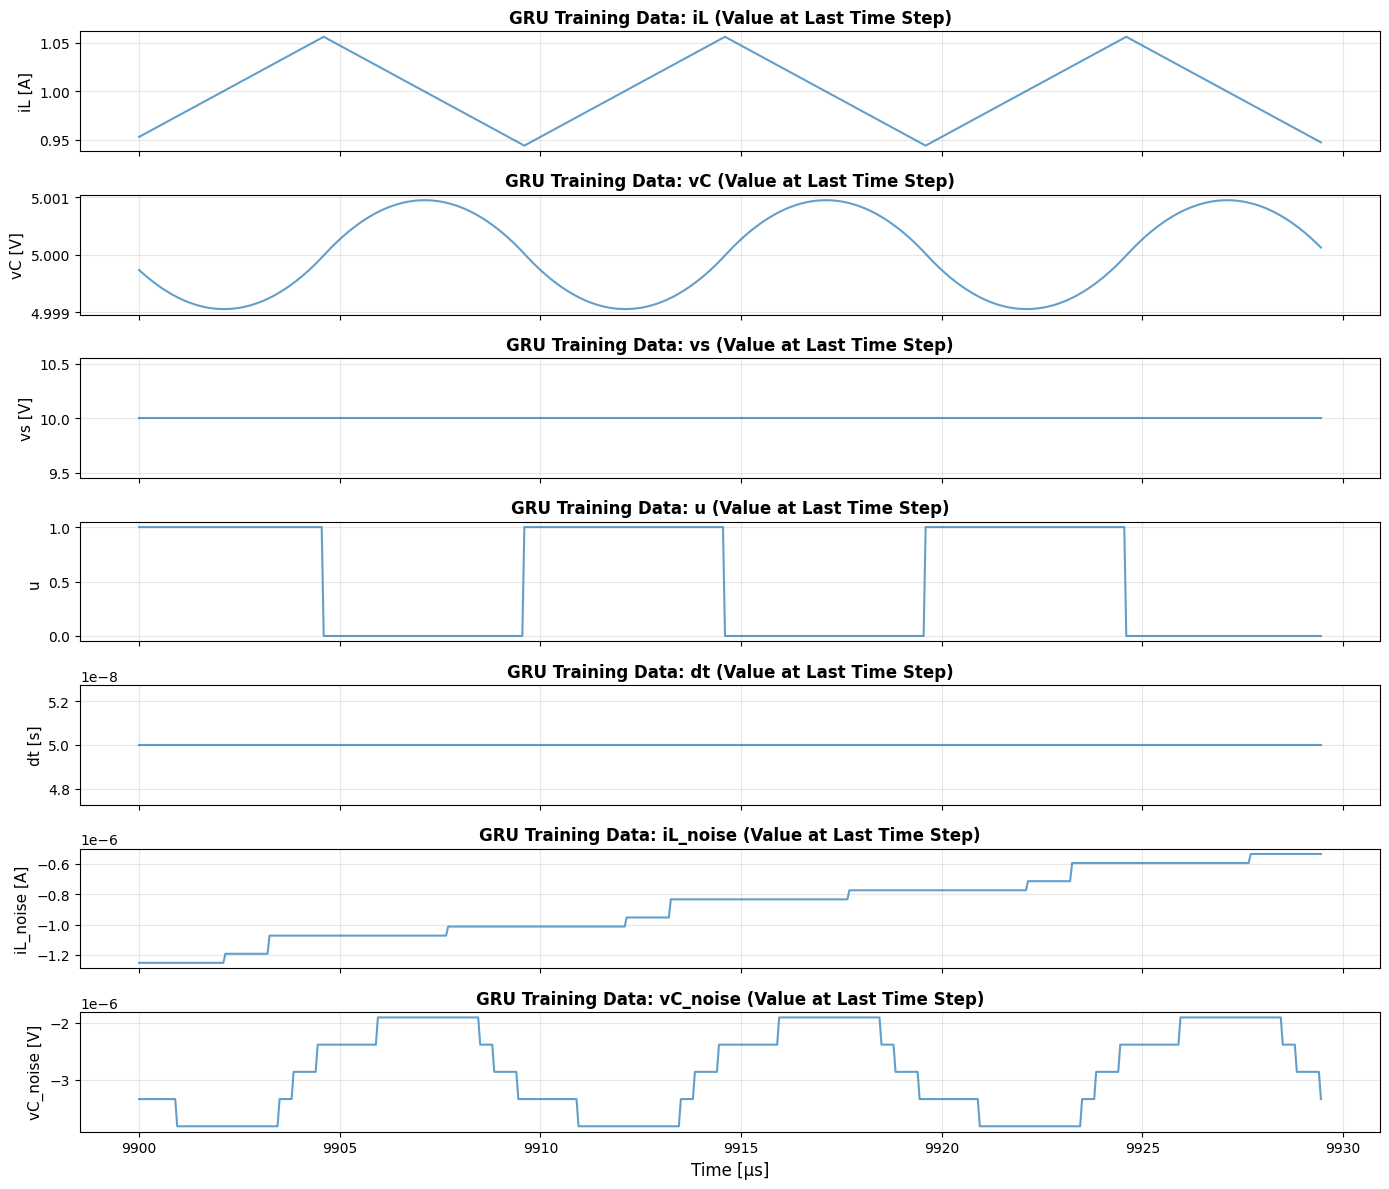

In [13]:
# 学習データ
X_train_seq_np: np.ndarray = X_train_seq.detach().cpu().numpy()
y_train_seq_np: np.ndarray = y_train_seq.detach().cpu().numpy()

# 入力特徴量名と単位
feature_names: list[str] = ["iL", "vC", "vs", "u", "dt", "iL_noise", "vC_noise"]
feature_units: list[str] = ["[A]", "[V]", "[V]", "", "[s]", "[A]", "[V]"]


fig, axs = plt.subplots(7, 1, figsize=(14, 12), sharex=True)

last_timestep_features: np.ndarray = X_train_seq_np[:, -1, :]  # [N, 7]

# time_axisをt_train（μs単位）に
time_axis: np.ndarray = t_train[: X_train_seq_np.shape[0]] * 1e6  # μs

for i in range(7):
    axs[i].plot(time_axis, last_timestep_features[:, i], linewidth=1.5, alpha=0.7)
    axs[i].set_ylabel(f"{feature_names[i]} {feature_units[i]}", fontsize=11)
    axs[i].grid(True, alpha=0.3)
    axs[i].set_title(
        f"GRU Training Data: {feature_names[i]} (Value at Last Time Step)",
        fontsize=12,
        fontweight="bold",
    )

axs[6].set_xlabel("Time [μs]", fontsize=12)
plt.tight_layout()
plt.show()

if keep_log:
    save_figure_to_log(
        fig,
        "gru_training_data_features",
        result_dir,
        "GRU 学習データ",
    )


## 学習


In [14]:
# 学習
gru_model = GRUModel(
    input_size=X_train_seq.shape[2],
    hidden_size=32,
    num_layers=2,
    output_size=2,
    seq_length=params.seq_length,
)


gru_optimizer = optim.Adam(gru_model.parameters(), lr=params.gru_lr)
gru_loss_fn = nn.MSELoss()

gru_loss_history = {"train": [], "valid": []}

for epoch in range(params.gru_epochs):
    # 学習モード
    gru_model.train()
    gru_optimizer.zero_grad()
    noise_pred_train = gru_model(X_train_seq)
    train_loss = gru_loss_fn(noise_pred_train, y_train_seq)
    train_loss.backward()
    gru_optimizer.step()

    gru_loss_history["train"].append(train_loss.item())

    # 検証モード
    gru_model.eval()
    with torch.no_grad():
        noise_pred_valid = gru_model(X_valid_seq)
        valid_loss = gru_loss_fn(noise_pred_valid, y_valid_seq)
        gru_loss_history["valid"].append(valid_loss.item())

    if (epoch + 1) % 50 == 0:
        print(
            f"Epoch {epoch + 1}/{params.gru_epochs}: "
            f"Train Loss={train_loss.item():.6e}, "
            f"Valid Loss={valid_loss.item():.6e}"
        )

gru_model.eval()
with torch.no_grad():
    noise_pred_test = gru_model(X_test_seq)
    test_loss = gru_loss_fn(noise_pred_test, y_test_seq)
    print(f"Test Loss={test_loss.item():.6e}")


Epoch 50/200: Train Loss=2.876123e-06, Valid Loss=1.028139e-05
Epoch 100/200: Train Loss=1.757050e-06, Valid Loss=1.461513e-06
Epoch 150/200: Train Loss=1.266380e-06, Valid Loss=1.264536e-06
Epoch 200/200: Train Loss=1.115714e-06, Valid Loss=1.113157e-06
Test Loss=1.140137e-06


## 結果確認


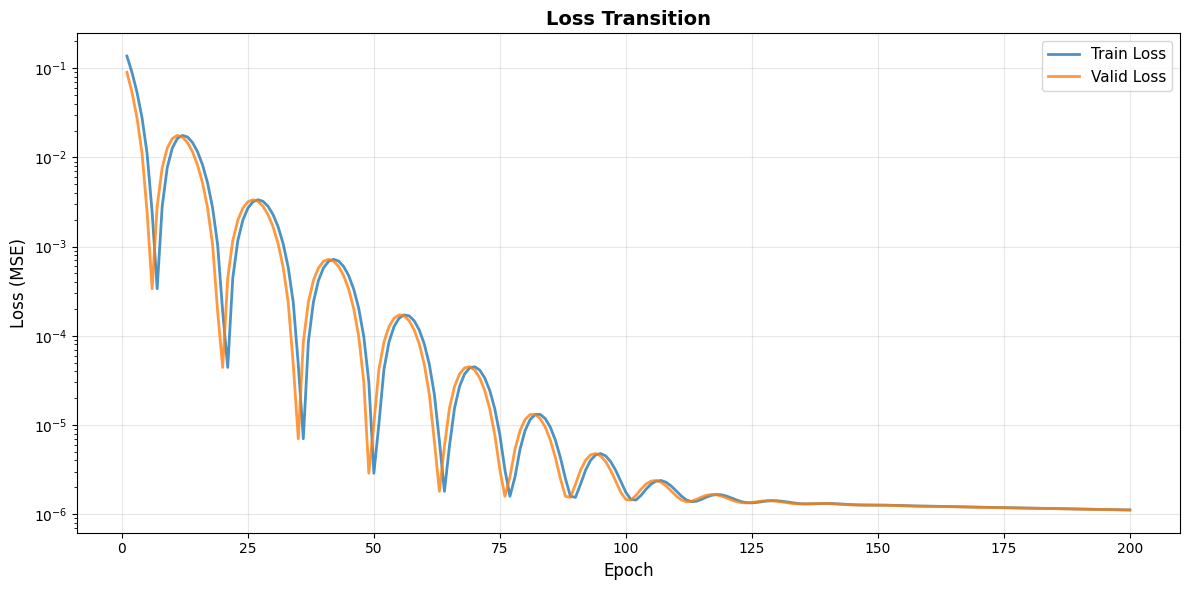

In [15]:
# Lossの遷移をグラフ表示
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

epochs_list = range(1, params.gru_epochs + 1)
ax.plot(
    epochs_list, gru_loss_history["train"], label="Train Loss", linewidth=2, alpha=0.8
)
ax.plot(
    epochs_list, gru_loss_history["valid"], label="Valid Loss", linewidth=2, alpha=0.8
)

ax.set_xlabel("Epoch", fontsize=12)
ax.set_ylabel("Loss (MSE)", fontsize=12)
ax.set_title("Loss Transition", fontsize=14, fontweight="bold")
ax.set_yscale("log")
ax.grid(True, alpha=0.3)
ax.legend(fontsize=11)

plt.tight_layout()
plt.show()

# 画像をログに保存
if keep_log:
    save_figure_to_log(fig, "gru_loss_transition", result_dir, "GRU Lossの遷移")


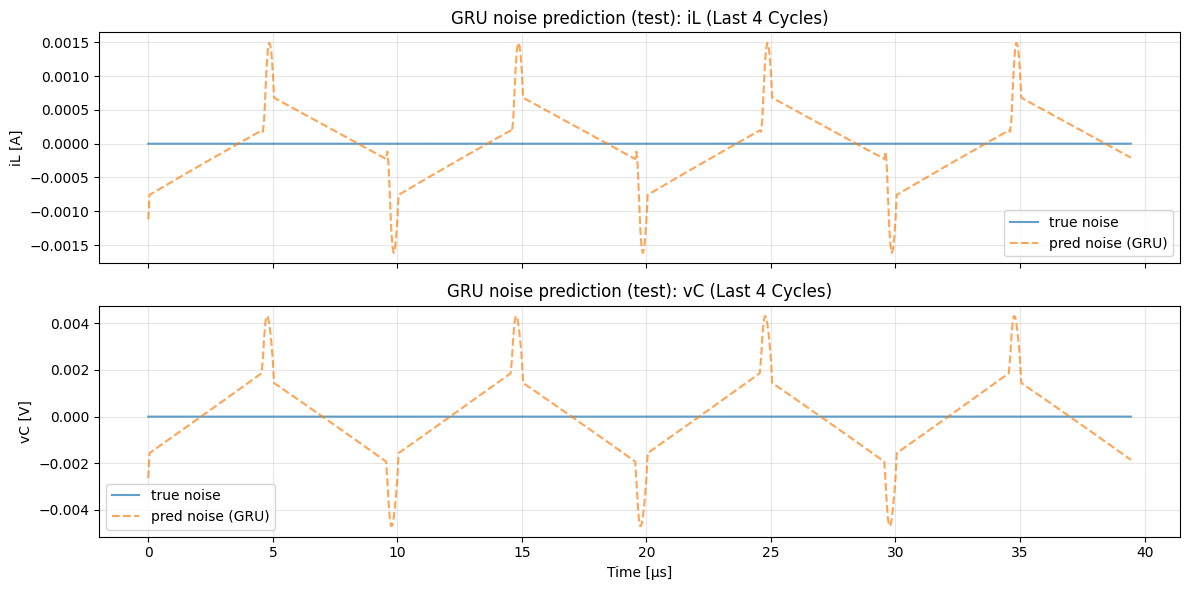

In [16]:
# GRUでノイズを予測（テスト）
gru_model.eval()
with torch.no_grad():
    noise_pred_test = gru_model(X_test_seq)


noise_pred_test_cpu = noise_pred_test.detach().cpu()
noise_true_test_cpu = y_test_seq.detach().cpu()

# plot_compare_tail を使って比較（末尾N周期）
seq_len = int(params.seq_length)

t_noise = np.asarray(t_test[:-1])[seq_len:]
min_len = min(
    t_noise.shape[0],
    int(noise_true_test_cpu.shape[0]),
    int(noise_pred_test_cpu.shape[0]),
)

t_noise = t_noise[:min_len]
true_noise = noise_true_test_cpu[:min_len].numpy()
pred_noise = noise_pred_test_cpu[:min_len].numpy()

fig1, _ = plot_compare_tail(
    t1=t_noise,
    iL1=true_noise[:, 0],
    vC1=true_noise[:, 1],
    label1="true noise",
    t2=t_noise,
    iL2=pred_noise[:, 0],
    vC2=pred_noise[:, 1],
    label2="pred noise (GRU)",
    T=float(params.T),
    N_cycles=4,
    title="GRU noise prediction (test)",
)


if keep_log:
    save_figure_to_log(
        fig1,
        "gru_noise_pred_test_tail10T",
        result_dir,
        "GRU noise予測(テスト, tail10T)",
    )


# BuckConverterCell + GRU の結果


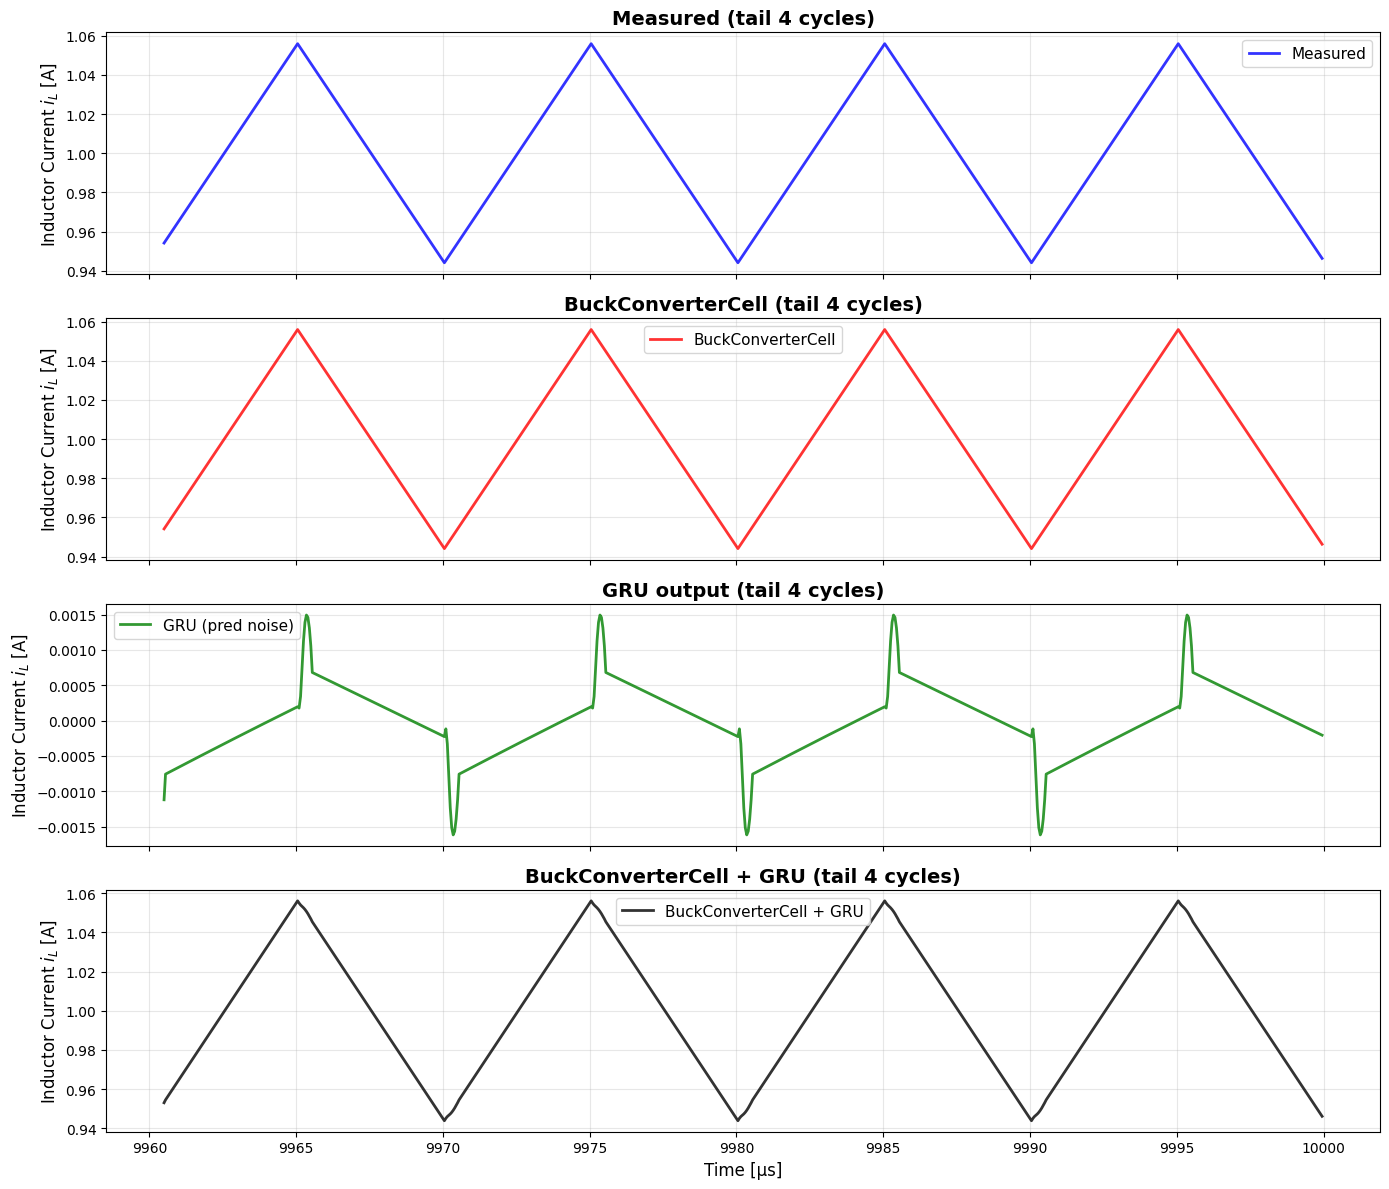

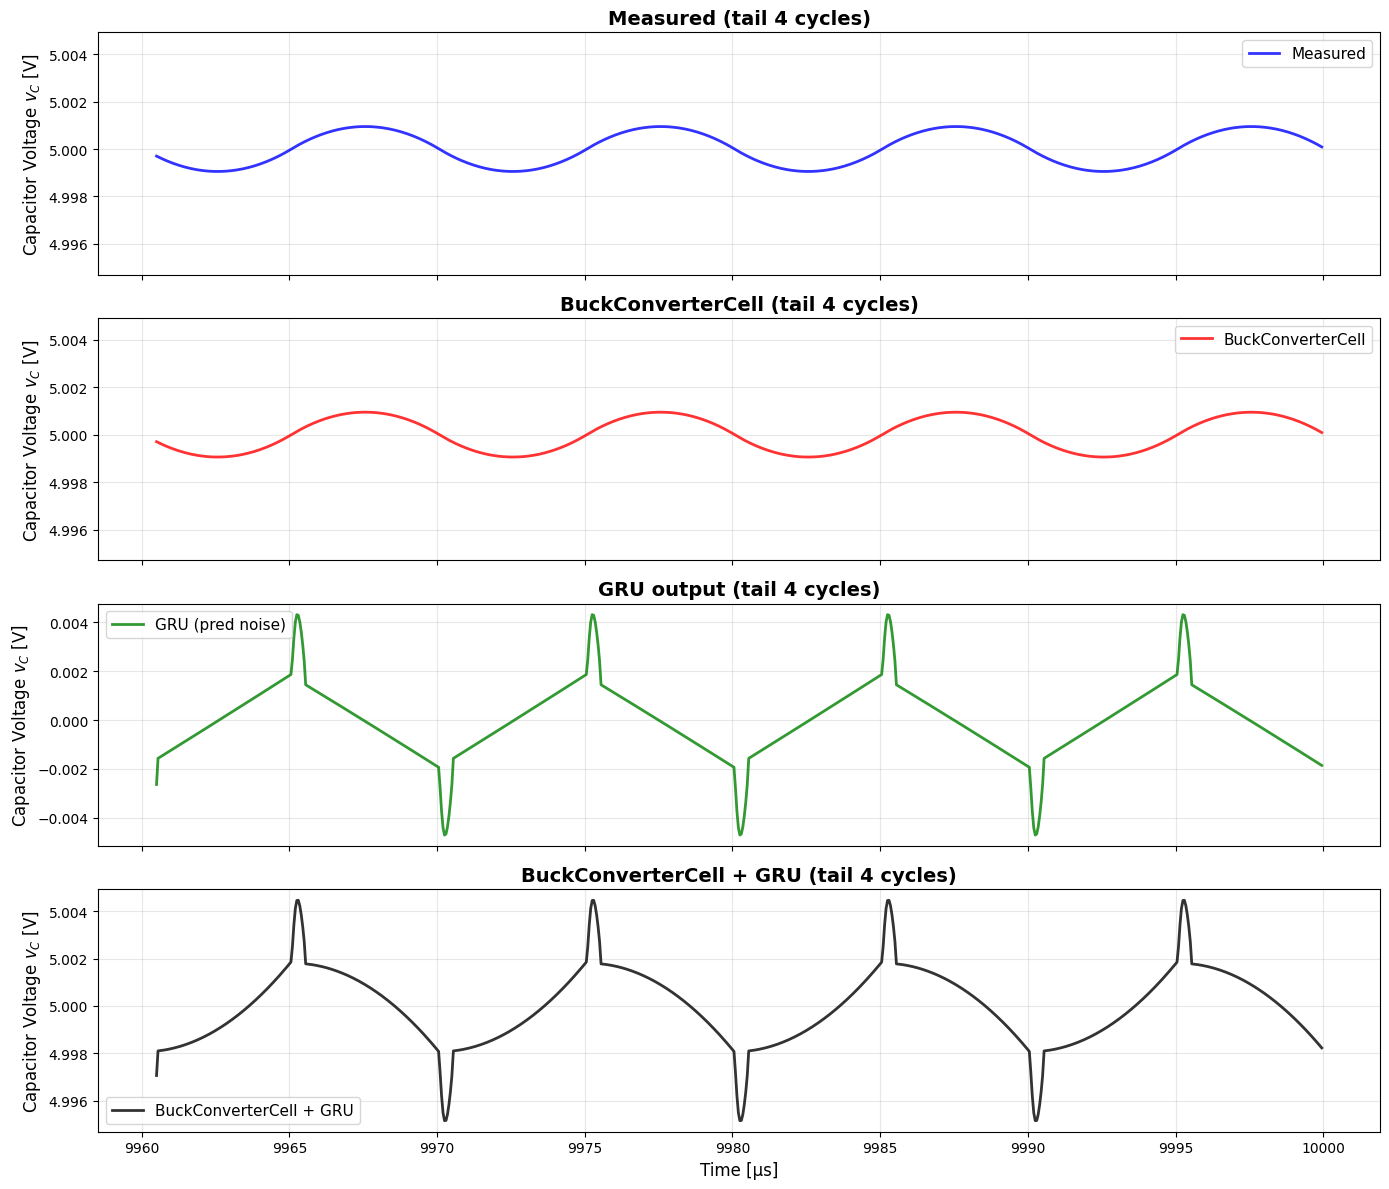

In [17]:
# プロット
N_cycles: int = 4
T: float = float(params.T)
seq_len: int = int(params.seq_length)

# --- BuckConverterCell: 実機時間(t_downsampled)に対応する末尾部分を抽出 ---
n_meas: int = int(len(t_downsampled))
t_sim_meas_raw: np.ndarray = np.asarray(t_sim[-n_meas:], dtype=float)

iL_sim_meas: np.ndarray = np.asarray(
    iL_sim[-n_meas:].detach().cpu().numpy(), dtype=float
)
vC_sim_meas: np.ndarray = np.asarray(
    vC_sim[-n_meas:].detach().cpu().numpy(), dtype=float
)

# t_simの末尾は (t_downsampled + オフセット) なので、オフセットを引いて合わせる
offset: float = float(t_sim_meas_raw[0] - float(t_downsampled[0]))
t_sim_meas: np.ndarray = t_sim_meas_raw - offset  # ≒ t_downsampled

# --- test区間をBuck側の時間で切り出す ---
t_test_np: np.ndarray = np.asarray(t_test, dtype=float)
start_idx: int = int(np.argmin(np.abs(t_sim_meas - float(t_test_np[0]))))
end_idx: int = min(start_idx + int(t_test_np.shape[0]), int(t_sim_meas.shape[0]))

t_test_used: np.ndarray = t_sim_meas[start_idx:end_idx]
iL_sim_test: np.ndarray = iL_sim_meas[start_idx:end_idx]
vC_sim_test: np.ndarray = vC_sim_meas[start_idx:end_idx]

# --- Measured(test) を同じ長さだけ取り出す ---
start_test_idx: int = int(train_len + valid_len)  # t_testと同じ開始位置

iL_meas_test: np.ndarray = np.asarray(
    iL_downsampled[start_test_idx : start_test_idx + int(t_test_used.shape[0])],
    dtype=float,
)
vC_meas_test: np.ndarray = np.asarray(
    vC_downsampled[start_test_idx : start_test_idx + int(t_test_used.shape[0])],
    dtype=float,
)

# --- GRU出力(pred_noise)は t_test[:-1][seq_len:] に対応 ---
t_noise_local: np.ndarray = np.asarray(t_test_used[:-1], dtype=float)[seq_len:]
pred_noise_np: np.ndarray = np.asarray(pred_noise, dtype=float)

min_len2: int = int(
    min(
        t_noise_local.shape[0],
        pred_noise_np.shape[0],
        iL_sim_test.shape[0] - 1 - seq_len,
        vC_sim_test.shape[0] - 1 - seq_len,
        iL_meas_test.shape[0] - 1 - seq_len,
        vC_meas_test.shape[0] - 1 - seq_len,
    )
)

if min_len2 <= 0:
    raise ValueError(
        "長さが合わず、描画できません。"
        " t_test/t_sim/pred_noise/seq_length の整合を確認してください。"
    )

t_noise_local = t_noise_local[:min_len2]
pred_noise_np = pred_noise_np[:min_len2]

# 4系列（すべて同じ長さ）
iL_meas: np.ndarray = np.asarray(iL_meas_test[:-1], dtype=float)[
    seq_len : seq_len + min_len2
]
vC_meas: np.ndarray = np.asarray(vC_meas_test[:-1], dtype=float)[
    seq_len : seq_len + min_len2
]

iL_buck: np.ndarray = np.asarray(iL_sim_test[:-1], dtype=float)[
    seq_len : seq_len + min_len2
]
vC_buck: np.ndarray = np.asarray(vC_sim_test[:-1], dtype=float)[
    seq_len : seq_len + min_len2
]

iL_gru: np.ndarray = pred_noise_np[:, 0]
vC_gru: np.ndarray = pred_noise_np[:, 1]

iL_sum: np.ndarray = iL_buck + iL_gru
vC_sum: np.ndarray = vC_buck + vC_gru

# --- 末尾4周期だけ表示（時間で切る） ---
t0: float = float(t_noise_local[-1] - N_cycles * T)
mask: np.ndarray = t_noise_local >= t0
x_us: np.ndarray = t_noise_local[mask] * 1e6


# y軸範囲（4系列まとめて揃える）
def _ylim(*arrs: np.ndarray) -> tuple[float, float]:
    y_min = float(min(np.min(a) for a in arrs))
    y_max = float(max(np.max(a) for a in arrs))
    y_rng = y_max - y_min
    return (y_min - 0.05 * y_rng, y_max + 0.05 * y_rng)


iL_ylim = _ylim(iL_meas[mask], iL_buck[mask], iL_sum[mask])
vC_ylim = _ylim(vC_meas[mask], vC_buck[mask], vC_sum[mask])

# --- iL: 4波形 ---
fig_iL, axs_iL = plt.subplots(4, 1, figsize=(14, 12), sharex=True)

axs_iL[0].plot(
    x_us, iL_meas[mask], label="Measured", linewidth=2, alpha=0.8, color="blue"
)
axs_iL[0].set_ylabel("Inductor Current $i_L$ [A]", fontsize=12)
axs_iL[0].set_title("Measured (tail 4 cycles)", fontsize=14, fontweight="bold")
axs_iL[0].set_ylim(iL_ylim)
axs_iL[0].grid(True, alpha=0.3)
axs_iL[0].legend(fontsize=11)

axs_iL[1].plot(
    x_us, iL_buck[mask], label="BuckConverterCell", linewidth=2, alpha=0.8, color="red"
)
axs_iL[1].set_ylabel("Inductor Current $i_L$ [A]", fontsize=12)
axs_iL[1].set_title("BuckConverterCell (tail 4 cycles)", fontsize=14, fontweight="bold")
axs_iL[1].set_ylim(iL_ylim)
axs_iL[1].grid(True, alpha=0.3)
axs_iL[1].legend(fontsize=11)

axs_iL[2].plot(
    x_us, iL_gru[mask], label="GRU (pred noise)", linewidth=2, alpha=0.8, color="green"
)
axs_iL[2].set_ylabel("Inductor Current $i_L$ [A]", fontsize=12)
axs_iL[2].set_title("GRU output (tail 4 cycles)", fontsize=14, fontweight="bold")
# axs_iL[2].set_ylim(iL_ylim)
axs_iL[2].grid(True, alpha=0.3)
axs_iL[2].legend(fontsize=11)

axs_iL[3].plot(
    x_us,
    iL_sum[mask],
    label="BuckConverterCell + GRU",
    linewidth=2,
    alpha=0.8,
    color="black",
)
axs_iL[3].set_ylabel("Inductor Current $i_L$ [A]", fontsize=12)
axs_iL[3].set_xlabel("Time [μs]", fontsize=12)
axs_iL[3].set_title(
    "BuckConverterCell + GRU (tail 4 cycles)", fontsize=14, fontweight="bold"
)
axs_iL[3].set_ylim(iL_ylim)
axs_iL[3].grid(True, alpha=0.3)
axs_iL[3].legend(fontsize=11)

plt.tight_layout()
plt.show()

# --- vC: 4波形 ---
fig_vC, axs_vC = plt.subplots(4, 1, figsize=(14, 12), sharex=True)

axs_vC[0].plot(
    x_us, vC_meas[mask], label="Measured", linewidth=2, alpha=0.8, color="blue"
)
axs_vC[0].set_ylabel("Capacitor Voltage $v_C$ [V]", fontsize=12)
axs_vC[0].set_title("Measured (tail 4 cycles)", fontsize=14, fontweight="bold")
axs_vC[0].set_ylim(vC_ylim)
axs_vC[0].grid(True, alpha=0.3)
axs_vC[0].legend(fontsize=11)

axs_vC[1].plot(
    x_us, vC_buck[mask], label="BuckConverterCell", linewidth=2, alpha=0.8, color="red"
)
axs_vC[1].set_ylabel("Capacitor Voltage $v_C$ [V]", fontsize=12)
axs_vC[1].set_title("BuckConverterCell (tail 4 cycles)", fontsize=14, fontweight="bold")
axs_vC[1].set_ylim(vC_ylim)
axs_vC[1].grid(True, alpha=0.3)
axs_vC[1].legend(fontsize=11)

axs_vC[2].plot(
    x_us, vC_gru[mask], label="GRU (pred noise)", linewidth=2, alpha=0.8, color="green"
)
axs_vC[2].set_ylabel("Capacitor Voltage $v_C$ [V]", fontsize=12)
axs_vC[2].set_title("GRU output (tail 4 cycles)", fontsize=14, fontweight="bold")
# axs_vC[2].set_ylim(vC_ylim)
axs_vC[2].grid(True, alpha=0.3)
axs_vC[2].legend(fontsize=11)

axs_vC[3].plot(
    x_us,
    vC_sum[mask],
    label="BuckConverterCell + GRU",
    linewidth=2,
    alpha=0.8,
    color="black",
)
axs_vC[3].set_ylabel("Capacitor Voltage $v_C$ [V]", fontsize=12)
axs_vC[3].set_xlabel("Time [μs]", fontsize=12)
axs_vC[3].set_title(
    "BuckConverterCell + GRU (tail 4 cycles)", fontsize=14, fontweight="bold"
)
axs_vC[3].set_ylim(vC_ylim)
axs_vC[3].grid(True, alpha=0.3)
axs_vC[3].legend(fontsize=11)

plt.tight_layout()
plt.show()

if keep_log:
    save_figure_to_log(
        fig_iL,
        "tail4T_iL_meas_buck_gru_sum",
        result_dir,
        "iL: Measured / Buck / GRU / Buck+GRU（末尾4周期）",
    )
    save_figure_to_log(
        fig_vC,
        "tail4T_vC_meas_buck_gru_sum",
        result_dir,
        "vC: Measured / Buck / GRU / Buck+GRU（末尾4周期）",
    )
